In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from model import ModeleAR, KrigingModel
from utils import load_transform, load_soil_data, model_gaussien, model_spherique

/home/florian/Documents/UdS/ModelesHierarchiques/IFT813/utils.py:19: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filename, sep="\s+", skiprows=4, header=None)


ImportError: cannot import name 'modele_exponentiel' from 'utils' (/home/florian/Documents/UdS/ModelesHierarchiques/IFT813/utils.py)

## Exercice 1 : Prix IBM

In [ ]:
dates, prix_orig, data_stat = load_transform("data/IBM.txt")

# On teste les ordres p de 1 à 25
resultats_aic = []
erreurs_mse = []
plage_p = range(1, 26)
lambda_reg = 0.1

In [ ]:
for p in plage_p:
    model = ModeleAR(p=p, lambda_reg=lambda_reg)
    model.fit(data_stat)
    erreurs_mse.append(model.sigma_e)

# Le meilleur ordre est celui qui minimise l'erreur 
best_p = np.argmin(erreurs_mse) + 1

# Estimation du modèle final
final_model = ModeleAR(p=best_p, lambda_reg=lambda_reg)
final_model.fit(data_stat)

# Synthèse de nouvelles données
data_synth = final_model.synthetiser(data_stat, len(data_stat))

### Visualisation

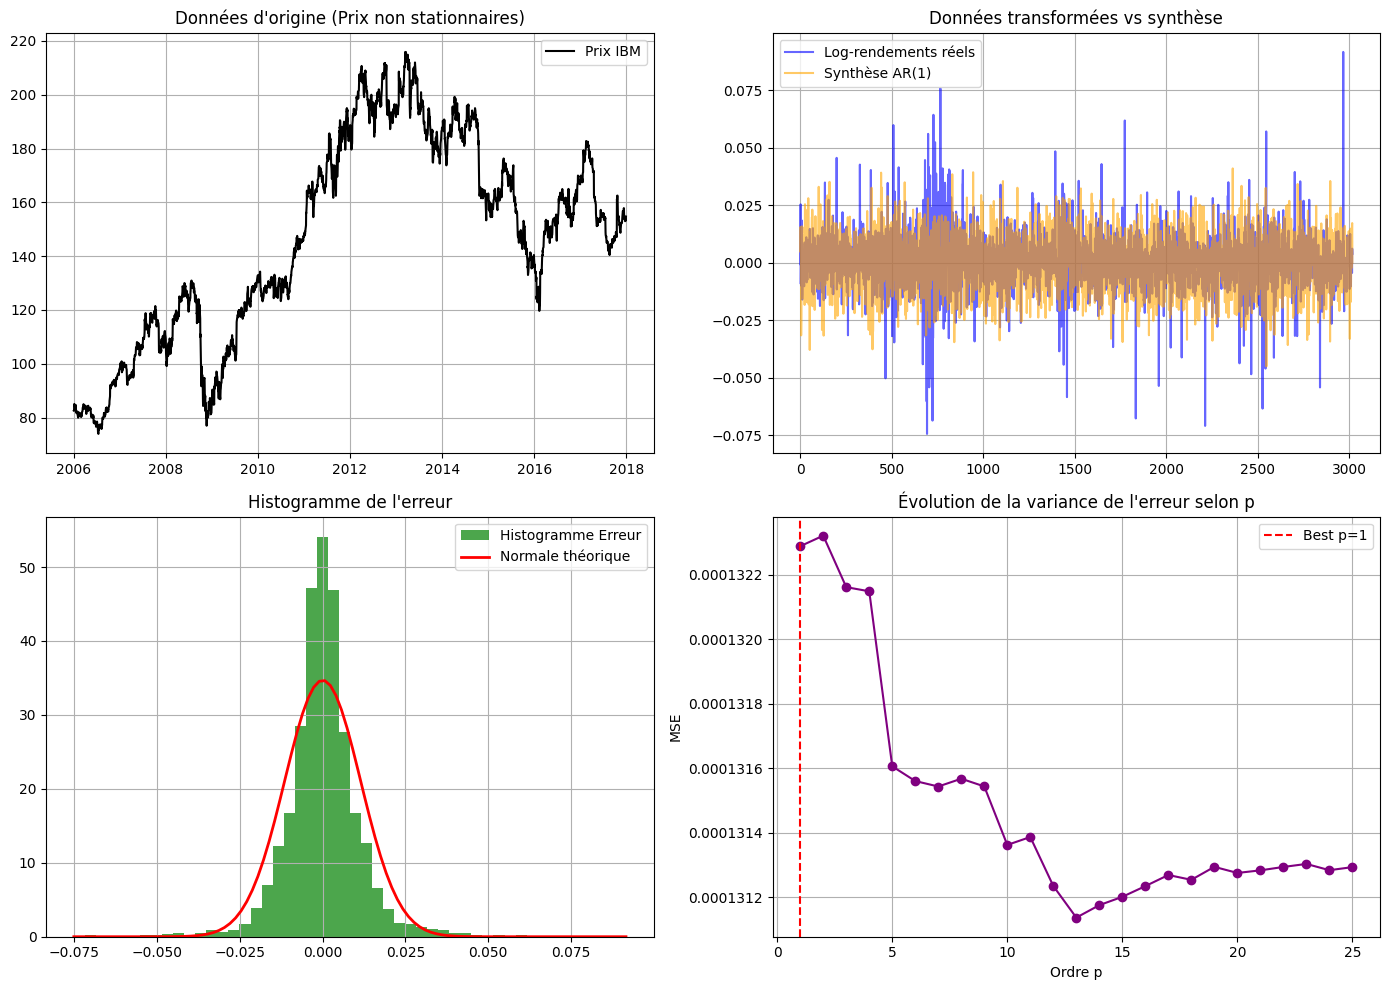

In [ ]:
# Visualisations
plt.figure(figsize=(14, 10))

# Données d'origine
plt.subplot(2, 2, 1)
plt.plot(dates, prix_orig, color="black", label="Prix IBM")
plt.title("Données d'origine (Prix non stationnaires)")
plt.legend()
plt.grid(True)

# Données stationnaires vs Synthèse
plt.subplot(2, 2, 2)
plt.plot(data_stat, color="blue", alpha=0.6, label="Log-rendements réels")
plt.plot(data_synth, color="orange", alpha=0.6, label=f"Synthèse AR({best_p})")
plt.title(f"Données transformées vs synthèse")
plt.legend()
plt.grid(True)

# Histogramme de l'erreur
X_mat, Y_vec = final_model.compute_matrix(data_stat)
pred_finale = X_mat @ final_model.coeffs
residus_finaux = Y_vec - pred_finale

plt.subplot(2, 2, 3)
plt.hist(
    residus_finaux,
    bins=50,
    color="green",
    density=True,
    alpha=0.7,
    label="Histogramme Erreur",
)
# Ajout courbe normale théorique pour vérifier l'hypothèse Gaussienne
x_axis = np.linspace(min(residus_finaux), max(residus_finaux), 100)
pdf_theorique = norm.pdf(x_axis, 0, np.sqrt(final_model.sigma_e))
plt.plot(x_axis, pdf_theorique, "r-", linewidth=2, label="Normale théorique")
plt.title("Histogramme de l'erreur")
plt.legend()
plt.grid(True)

# Graphe 4 : Évolution de l'erreur (Choix de l'ordre)
plt.subplot(2, 2, 4)
plt.plot(plage_p, erreurs_mse, marker="o", color="purple")
plt.axvline(x=best_p, color="red", linestyle="--", label=f"Best p={best_p}")
plt.title("Évolution de la variance de l'erreur selon p")
plt.xlabel("Ordre p")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Exercice 2 : pH du sol

In [ ]:
X, Y, pH = load_soil_data("data/Soil.dat")

# Création et entraînement des modèles
model_sph = KrigingModel("spherical")
lags, gammas = model_sph.fit(X, Y, pH)
model_exp = KrigingModel("gaussian")
lags, gammas = model_exp.fit(X, Y, pH)  # On fit aussi le gaussien pour comparer

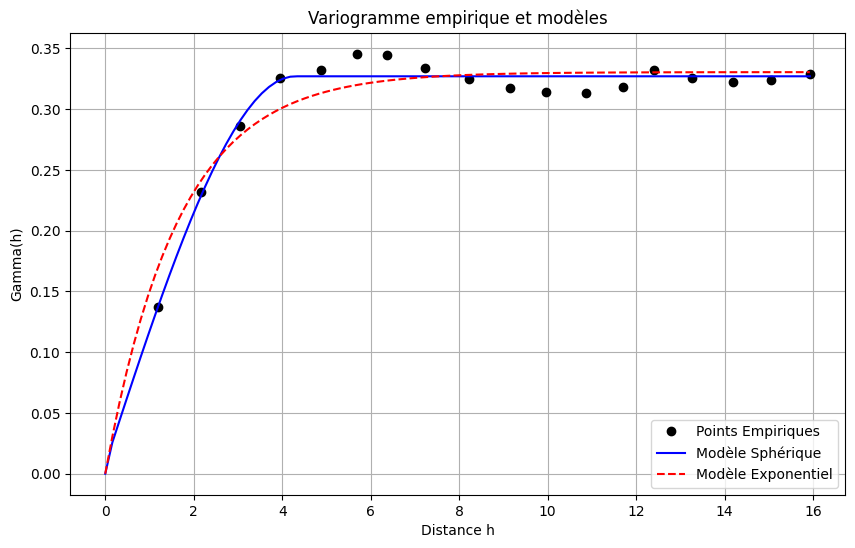

In [ ]:
# Visualisation du variogramme
h = np.linspace(0, max(lags), 100)
plt.figure(figsize=(10, 6))
plt.plot(lags, gammas, "ko", label="Points empiriques")
plt.plot(h, modele_spherique(h, *model_sph.params), "b-", label="Modèle sphérique")
plt.plot(h, modele_exponentiel(h, *model_exp.params), "r--", label="Modèle gaussien")
plt.title("Variogramme empirique et modèles")
plt.xlabel("Distance h")
plt.ylabel("Gamma(h)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Prédictions (Question 4)
points_test = [
    (np.mean(X), np.mean(Y)),  # Au milieu du champ
    (np.min(X), np.min(Y)),  
    (np.max(X), np.max(Y)),  
]

print("\n--- Prédictions de pH aux points test ---")
print(f"{'Modèle':<12} {'X':<8} {'Y':<8} {'pH Prédit':<10} {'Erreur':<10}")

for px, py in points_test:
    # Prédiction sphérique
    val_s, err_s = model_sph.predict(px, py)
    print(f"{'Sphérique':<12} {px:<8.1f} {py:<8.1f} {val_s:<10.4f} {err_s:<10.4f}")

    # Prédiction exponentielle
    val_e, err_e = model_exp.predict(px, py)
    print(f"{'Gaussien':<12} {px:<8.1f} {py:<8.1f} {val_e:<10.4f} {err_e:<10.4f}")
    print("-" * 60)


--- PRÉDICTIONS KRIGEAGE ---
Modèle       X        Y        pH Prédit  Erreur    
Sphérique    10.3     16.8     7.9602     0.0618    
Exponentielle 10.3     16.8     7.9925     0.0894    
------------------------------------------------------------
Sphérique    1.0      1.0      7.9539     0.2794    
Exponentielle 1.0      1.0      7.9844     0.2987    
------------------------------------------------------------
Sphérique    18.0     31.0     8.1356     0.2621    
Exponentielle 18.0     31.0     8.0382     0.2908    
------------------------------------------------------------
